# Tutorial 5: Ensemble Methods (STAT8017)

- **Time: Feb.26, 9:00-9:50p.m.**

### Content

* [Introduction](#S1)
* [Bootstrap Aggregating](#S2)
* [Random Forest](#S3)
* [Boosting](#S4)

### The packages to be used in this tutorial: 
- numpy 
- scipy
- matplotlib
- sklearn

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True, precision=3)

In this tutorial, we use the california housing dataset to illustrate ensemble learning method.

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
california = fetch_california_housing()
x = pd.DataFrame(california.data, columns=california.feature_names)
y = pd.DataFrame(california.target, columns=["Price"])
x.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [3]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=8017)

First, let's build a single regression tree. 

In [4]:
from sklearn.tree import DecisionTreeRegressor

reg_tree_california = DecisionTreeRegressor(max_depth=6, random_state=8017)
reg_tree_california.fit(x_train, y_train)
np.round(reg_tree_california.score(x_test, y_test), 4)

0.6497

**Remark**: A single regression tree (with max_depth=6) scores 0.6497 (the larger, the better) on the test set. 

To improve the prediction performance, we can optimize its hyperparameter - `max_depth`, as follows.

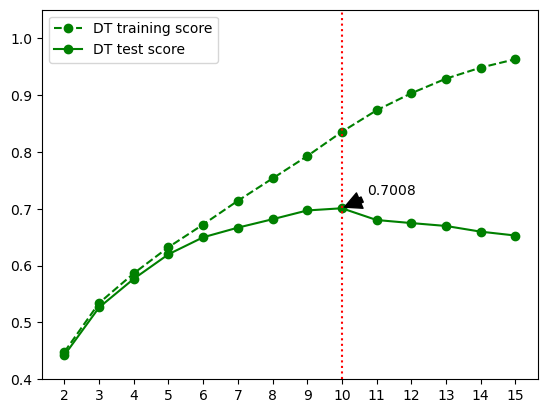

In [5]:
#  grid search best depth
train_single_scores = []
test_single_scores = []
for depth in range(2, 16):
    reg_tree_california = DecisionTreeRegressor(max_depth=depth, random_state=8017)
    reg_tree_california.fit(x_train, y_train)
    train_single_scores.append(reg_tree_california.score(x_train, y_train))
    test_single_scores.append(reg_tree_california.score(x_test, y_test))
# plot the performance for each tree
plt.plot(train_single_scores, "go--")
plt.plot(test_single_scores, "go-")
plt.ylim(0.4, 1.05)
plt.xticks(range(14), range(2, 16))
plt.legend(["DT training score", "DT test score"])
# annotate the best model
plt.axvline(np.argmax(test_single_scores), linestyle="dotted", color="red")
plt.annotate(np.max(test_single_scores).round(4), (np.argmax(test_single_scores), np.max(test_single_scores)), xycoords="data",
                 xytext=(50, 25), textcoords="offset pixels", arrowprops=dict(facecolor="black", shrink=0.1), fontsize=10,
                 horizontalalignment="center", verticalalignment="top")
plt.show()

**Remark**: The test score is improved from 0.6497 to 0.7008. However, we observe the overfiting problem as a larger max_depth is used.

## Introduction to ensemble learning <a class="anchor" id="S1"></a>

![avatar](./images/Bias_Variance.png)

- The bias error is an error from erroneous assumptions in the learning algorithm. High bias can cause an algorithm to miss the relevant relations between features and target outputs (underfitting).
- The variance is an error from sensitivity to small fluctuations in the training set. High variance may result from an algorithm modeling the random noise in the training data (overfitting).
- Simple models usually have large bias but small variance.
- Complex models usually have small bias but large variance.
- Ensemble learning can help reduce the variance of complex models. 

## Bootstrap Aggregating (Bagging)  <a class="anchor" id="S2"></a>

- Bagging (or Bootstrap aggregation) is one modern technique for reducing the variance of an algorithm  (here is a tree). The key idea is to generate $B$ new training sets by sampling from the original training set uniformly and with replacement, then take average of the fitted functions (here are tree ensemble) values on these sets.

- Bagging can be applied on any estimated prediction function, especially those with great variance but low bias.

$$
\hat{f}_\mathrm{bag}(x) = \frac1B \sum_{b=1}^B \hat{f}_b(x)
$$

Bagging method can be implemented with following steps:
- Replicate our data set multiple times through Bootstrap by sampling with replacement.
- Fit a base learner (here we use the single regression tree as example) on different Bootstrap subsets.
- Finally, the prediction results are averaged.

![avatar](./images/Bagging.png)

Let's see if we could improve the existing results of Decision Tree using **bagging** ([BaggingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html)).

```python
BaggingRegressor(base_estimator=None, n_estimators=10, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=None, random_state=None, verbose=0)
```

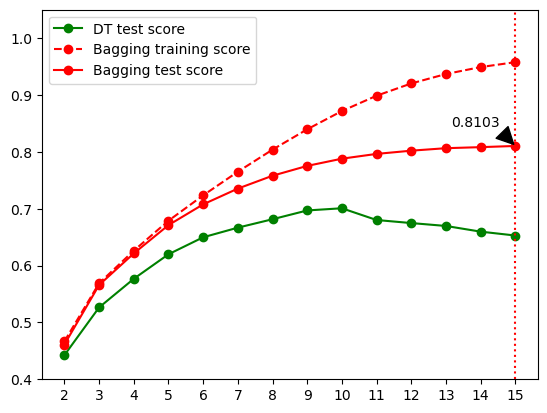

In [6]:
from sklearn.ensemble import BaggingRegressor

# training the trees in our bagging algorithm
train_bagging_scores = []
test_bagging_scores = []
for depth in range(2, 16):
#   The number of base estimators in the ensemble is 100.
    bagging_california = BaggingRegressor(DecisionTreeRegressor(max_depth=depth, random_state=8017), 
                                      n_estimators=100, random_state=8017)
    bagging_california.fit(x_train, y_train.values.ravel())
    train_bagging_scores.append(bagging_california.score(x_train, y_train))
    test_bagging_scores.append(bagging_california.score(x_test, y_test))

#     plot the performance for the single tree and the bagging model
plt.plot(test_single_scores, 'go-')
plt.plot(train_bagging_scores, 'ro--')
plt.plot(test_bagging_scores, 'ro-')
plt.ylim(0.4, 1.05)
plt.xticks(range(14), range(2, 16))
plt.legend(["DT test score", "Bagging training score", "Bagging test score"])
plt.axvline(np.argmax(test_bagging_scores), linestyle="dotted", color="red")
plt.annotate(np.max(test_bagging_scores).round(4), (np.argmax(test_bagging_scores), np.max(test_bagging_scores)), xycoords="data",
                 xytext=(-40, 30), textcoords="offset pixels", arrowprops=dict(facecolor="black", shrink=0.1), fontsize=10,
                 horizontalalignment="center", verticalalignment="top")
plt.show()

**Remark**: This time, it can be observed that the bagging algorithm (red) dominates single regression trees (green). The test score has been improved from 0.7008 to 0.8103, and the overfitting problem almost disappears.

## Random Forest <a class="anchor" id="S3"></a>

- Random forest provides a way of averaging multiple decision trees, trained on different variables of the same training set.

- The decrease in variance comes at the expense of a small increase in bias, but in general, its overall performance will be boosted.

- Random forest also suffers from the loss of interpretability, and therefore variable importance is proposed to interpret the fitted model. 

- Procedure for fitting a random forest
    - Perform Bagging sampling, and for each bagging set, randomly select $m$ variables out of $p$ variables ($m < p$);
    - Fit a basic learner (decision tree) for different bagging sets;
    - Repeat the above steps and obtain a set of trees (e.g., 100);
    - The prediction can be calculated via the simple average of different trees.

**Remark**: **Bagging** is simply a special case of **random forest** (see [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor) for more details).

```python 
RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False)
```

In [7]:
from sklearn.ensemble import RandomForestRegressor
# keep 5 features for each tree
regr_rf = RandomForestRegressor(n_estimators=100, max_features=5, random_state=8017)
regr_rf.fit(x_train, y_train.values.ravel())
np.round(regr_rf.score(x_test, y_test), 4)

0.8184

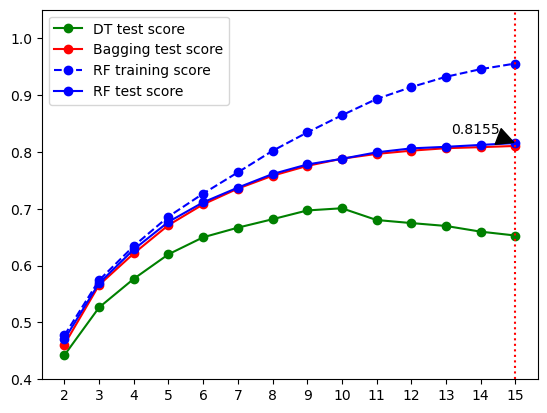

In [8]:
# training the trees in our random forest algorithm
train_rf_scores = []
test_rf_scores = []
for depth in range(2, 16):
    rf_california = RandomForestRegressor(n_estimators=100, max_depth=depth, max_features=5, random_state=8017)
    rf_california.fit(x_train, y_train.values.ravel())
    train_rf_scores.append(rf_california.score(x_train, y_train))
    test_rf_scores.append(rf_california.score(x_test, y_test))

#     plot the performance for the single tree and the bagging model and the random forest model
plt.plot(test_single_scores, 'go-')
plt.plot(test_bagging_scores, 'ro-')
plt.plot(train_rf_scores, 'bo--')
plt.plot(test_rf_scores, 'bo-')
plt.ylim(0.4, 1.05)
plt.xticks(range(14), range(2, 16))
plt.legend(["DT test score", "Bagging test score", "RF training score", "RF test score"])
plt.axvline(np.argmax(test_rf_scores), linestyle="dotted", color="red")
plt.annotate(np.max(test_rf_scores).round(4), (np.argmax(test_rf_scores), np.max(test_rf_scores)), xycoords="data",
                 xytext=(-40, 20), textcoords="offset pixels", arrowprops=dict(facecolor="black", shrink=0.1), fontsize=10,
                 horizontalalignment="center", verticalalignment="top")
plt.show()

**Remark**: The performance of Random forest is slightly better than that of Bagging. The test score has been improved from 0.8103 to 0.8155.

- [Feature Importances](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html): calculated from the accumulation of the impurity decrease within each tree.

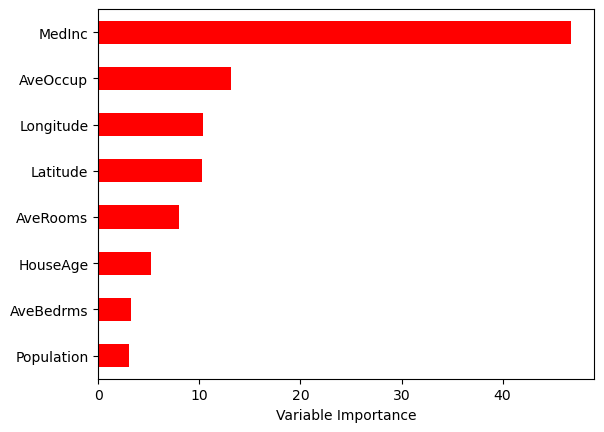

In [9]:
importance = pd.DataFrame({'Importance':regr_rf.feature_importances_*100}, index=x.columns)
importance.sort_values(by='Importance', axis=0, ascending=True).plot(kind='barh', color='r')
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

The results indicate that across all the trees considered in the random forest, **MedInc** and **AveOccup** are the two most important variables.

## Boosting <a class="anchor" id="S3"></a>   

- The main idea of boosting is to **adaptively improve the performance of a set of weak learners**.
- Let $\{(\mathbf{x}_i,y_i)\}_{i=1}^n$ denote the observations, $G_m(\mathbf{x})$ be a series of weak learners (e.g. tree or MLP). Our target is to learn a strong learner $f(\mathbf{x})=\sum_{m=1}^M\beta_m G_m(\mathbf{x})$ that fits the data well.
- Generally, given the loss function $L$, boosting method sequentially constructs the strong leaner by
$$(\hat{\beta}_m,\hat{G}_m)=\arg\min_{\beta_m, G_m}\sum_{i=1}^n L(y_i,f_{m-1}(\mathbf{x}_i)+\beta_m G_m(\mathbf{x}_i)),~\text{for}~m=1,\dots,M,$$
where $f_0(\mathbf{x})=\beta_0$. Note that in the $m$ th step, we fix the $f_{m-1}(\mathbf{x})$ and estimate the $\beta_m$ and $G_m$.
- There are multiple ways to learn $\beta_m, G_m$ such as the **Adaboost** and **Gradient Boosting**.
- Differences between bagging and boosting ([Source](https://www.kdnuggets.com/2017/11/difference-bagging-boosting.html)):
    - ![difference 1](./images/diff1.png)
    - ![difference 2](./images/diff2.png)
    

**Remark**: The base learners in Bagging and random forest can be performed in parallel, while in boosting, different base learners are performed one-by-one.

![avatar](./images/Boosting.png)

### Gradient Boosting

Gradient Boosting learns from the mistake - residual error directly. Refer to the documentation
[GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor).



- Suppose the loss function $L$ is differentiable, we apply the first-order Taylor expansion on the general loss and obtain
$$\mathcal{L}=\sum_{i=1}^n L(y_i,f_{m-1}(\mathbf{x}_i)+\beta_mG_m(\mathbf{x}_i))\simeq\sum_{i=1}^n L(y_i,f_{m-1}(\mathbf{x}_i))+\beta_m\sum_{i=1}^n \nabla_f L(y_i,f_{m-1}(\mathbf{x}_i))G_m(\mathbf{x}_i),$$  
   where $\nabla_f L(y_i,f_{m-1}(\mathbf{x}_i))=\frac{\partial L(y_i,f(\mathbf{x}_i))}{\partial f(\mathbf{x}_i)}\large|_{f=f_{m-1}}$.
It is easy to see that $\mathcal{L}$ decreases when $G_m(\mathbf{x}_i)=-\nabla_f L(y_i,f_{m-1}(\mathbf{x}_i))$ and $\beta_m$ be a proper number. So the main idea of the Gradient Boosting is iteratively:  
1. using a regression tree learner $G_m(\mathbf{x})$ to fit the negative gradient $-\nabla_f L(y_i,f_{m-1}(\mathbf{x}_i))$ such that for $G_m(\mathbf{x}_i)\simeq-\nabla_f L(y_i,f_{m-1}(\mathbf{x}_i))$ when $\mathbf{x}=\mathbf{x}_i$;  
2. optimizing $\hat{\beta}_m=\arg\min_{\beta_m}\sum_{i=1}^n L(y_i,f_{m-1}(\mathbf{x}_i)+\beta_mG_m(\mathbf{x}_i))$.


- Two regularization methods are widely applied in GB ([Source](https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting)):
     - *learning_rate* $v$: a small number to shrink the contribution of weak learner, $f_m(\mathbf{x})=f_{m-1}(\mathbf{x})+v\beta_mG_m(\mathbf{x})$.
     - *subsampling*: at each iteration, the learner is trained on a fraction of the data.
     
     
- Pros & Cons ([Source](https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting)):
    - Pros: strong predictive power in practice, handling mixed type data, robust to outliers with proper loss.
    - Cons: scalability (due to the sequential nature of fitting, taking huge computation resources or long training time).
    
    
- `GradientBoostingClassifier`([link](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)) and `GradientBoostingRegressor` ([link](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)) in `sklearn`, which have important parameters such as `n_estimators`, `learning_rate` and `subsample`.

```python 
GradientBoostingRegressor(loss='squared_error', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None, init=None, random_state=None, max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False, presort=’auto’, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001)
```

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# training the trees in our GB algorithm
train_gb_scores = []
test_gb_scores = []
for depth in range(2, 16):
    regr_gb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.01, max_depth=depth, random_state=8017)
    regr_gb.fit(x_train, y_train.values.ravel())
    train_gb_scores.append(regr_gb.score(x_train, y_train))
    test_gb_scores.append(regr_gb.score(x_test, y_test))

#  plot the performance of each method
plt.plot(test_single_scores, 'go-')
plt.plot(test_bagging_scores, 'ro-')
plt.plot(test_rf_scores, 'bo-')
plt.plot(train_gb_scores, 'yo--')
plt.plot(test_gb_scores, 'yo-')
plt.ylim(0.4, 1.05)
plt.xticks(range(14), range(2, 16))
plt.legend(["DT test score", "Bagging test score", "RF test score", "GB training score", "GB test score"])
plt.show()

**Remark**: The test score curve of Gradient Boosting have intersections with Bagging and RF.

### AdaBoost

AdaBoost learns from the mistakes by increasing the weight of misclassified data points.

- Weighting: At each iteration of the training process, a weight is assigned to each sample according to the error;
- Training: At each iteration, a weak learner is trained on the reweighted sample;
- Combination: Build a strong classifier as the weighted linear combination of the weak classifiers (based on their accuracy).

- For simplicity, we restrict our attention on the binary classification problem with $y\in\{-1,1\}$ and classifiers $G_m\in\{-1,1\}$.
- In AdaBoost, the exponential loss is applied $L(y,f(\mathbf{x}))=\exp(-y f(\mathbf{x}))$ and the fitting process can be rewritten as
$$
\begin{align*}
(\hat{\beta}_m,\hat{G}_m) 
&=\arg\min_{\beta_m, G_m}\sum_{i=1}^n \exp\left[-y_i(f_{m-1}(\mathbf{x}_i)+\beta_mG_m(\mathbf{x}_i))\right]\\
&=\arg\min_{\beta_m, G_m}\sum_{i=1}^n w_i^{(m)}\exp\left[-y_i\beta_mG_m(\mathbf{x}_i))\right],~\text{for}~m=1,\dots,M,
\end{align*}
$$
where $w_i^{(m)}=\exp(-y_if_{m-1}(\mathbf{x}_i))$ is the $i$ th sample weight that measures its 'error'.
- Given above formula, we can intuitively describe the Adaboost algorithm as follows:
    - Initialize the equal sample weights;
    - For $m=1,\dots, M$, increase and decrease the weights for misclassified and well-classified samples accordingly, and fit a weaker learner $G_m$ with its additive coefficient $\beta_m$ on the weighted data.
    - Make prediction by $\text{sign}(\sum_{m=1}\beta_mG_m(\mathbf{x}))$.
- [Figure source](https://campus.datacamp.com/courses/machine-learning-with-tree-based-models-in-python/boosting?ex=1)
![AdaBoost](./images/adaboost.png)
- There are many options of loss functions for classification, such as binomial deviance, hinge loss, squared-error loss, while for the regression problem, the loss function is typically chosen as squared-error loss or absolute-error loss.
- The weak learner in AdaBoost is not restricted in decision tree, it can also be, for example, the shallow and small neural network.
- Pros & Cons ([Chinese Source](https://www.cnblogs.com/pinard/p/6140514.html)): 
    - Pros: flexible, easy to implement and hard to overfit.
    - Cons: sensitive to the outliers.
- `AdaBoostClassifier` ([link](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier)) and `AdaBoostRegressor` ([link](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.AdaBoostRegressor)) :
    - `base_estimator`: the weak learner for boosting.
    - `learning_rate`: small float, the value that controlling the contribution of each learner, see the introduction of $v$ in Gradient Boosting.
    - `n_estimators` : integer, the maximum number of weak learner used in boosting.

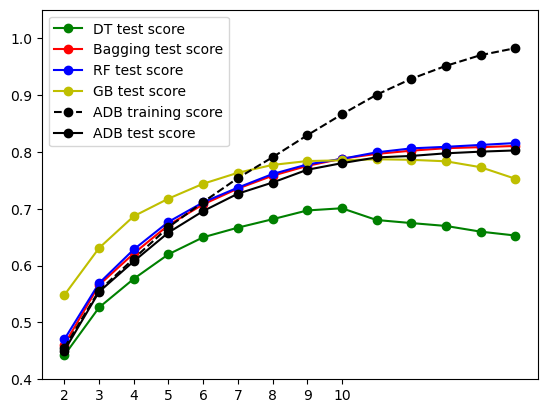

In [11]:
from sklearn.ensemble import AdaBoostRegressor

# training the trees in our AdaBoost algorithm
train_adb_scores = []
test_adb_scores = []
for depth in range(2, 16):
    regr_adb = AdaBoostRegressor(DecisionTreeRegressor(max_depth=depth), n_estimators=100, learning_rate=0.001, random_state=8017)
    regr_adb.fit(x_train, y_train.values.ravel())
    train_adb_scores.append(regr_adb.score(x_train, y_train))
    test_adb_scores.append(regr_adb.score(x_test, y_test))

#  plot the performance of each method
plt.plot(test_single_scores, 'go-')
plt.plot(test_bagging_scores, 'ro-')
plt.plot(test_rf_scores, 'bo-')
plt.plot(test_gb_scores, 'yo-')
plt.plot(train_adb_scores, 'ko--')
plt.plot(test_adb_scores, 'ko-')
plt.ylim(0.4, 1.05)
plt.xticks(range(9), range(2, 11))
plt.legend(["DT test score", "Bagging test score", "RF test score", "GB test score", "ADB training score", "ADB test score"])
plt.show()

***Remark***: All the compared ensemble learning methods outperform the single decision tree. Althought random forest tends to perform the best among compared methods, we cannot say that random forest is always the best, and the ranking of different ensemble learning algorithms may be different when other datasets are tested. 

## Thanks!

In [12]:
!jupyter nbconvert --to html Tutorial_5_Ensemble_Methods.ipynb

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot

Jupyter command `jupyter-nbconvert` not found.
